In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [ ]:
dataset_path = 'pictures'

IMG_WIDTH, IMG_HEIGHT = 150, 150

datagen = ImageDataGenerator(
    rescale=1./255,              
    validation_split=0.2,       
    shear_range=0.2,          
    zoom_range=0.2,       
    horizontal_flip=True    
)

train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=32,
    class_mode='categorical',
    subset='validation' 
)

test_generator = datagen.flow_from_directory(
    'path_to_test_data',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=32,
    class_mode='categorical'
)

In [10]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Abudefduf vaigiensis
1 : Acanthurus sohal
2 : Acropora sp
3 : Amphiprion bicinctus
4 : Aurelia aurita
5 : Caesio suevica
6 : Caranx sp
7 : Carcharhinus amblyrhynchos
8 : Cephalopholis miniata
9 : Chaetodon auriga
10 : Chelidonura flavolobata
11 : Chelonia mydas
12 : Choriaster granulatus
13 : Cyclichthys spilostylus
14 : Epinephelus fasciatus
15 : Epinephelus polyphekadion
16 : Goniobranchus annulatus
17 : Heniochus intermedius
18 : Heterocentrotus mamillatus
19 : Holacanthus ciliaris
20 : Holothuria atra
21 : Iago omanensis
22 : Millepora dichotoma
23 : Myrichthys maculosus
24 : Octopus vulgaris
25 : Plotosus lineatus
26 : Rhincodon typus
27 : Scarus sp
28 : Seriolina nigrofasciata
29 : Sphyraena barracuda
30 : Stegostoma tigrinum


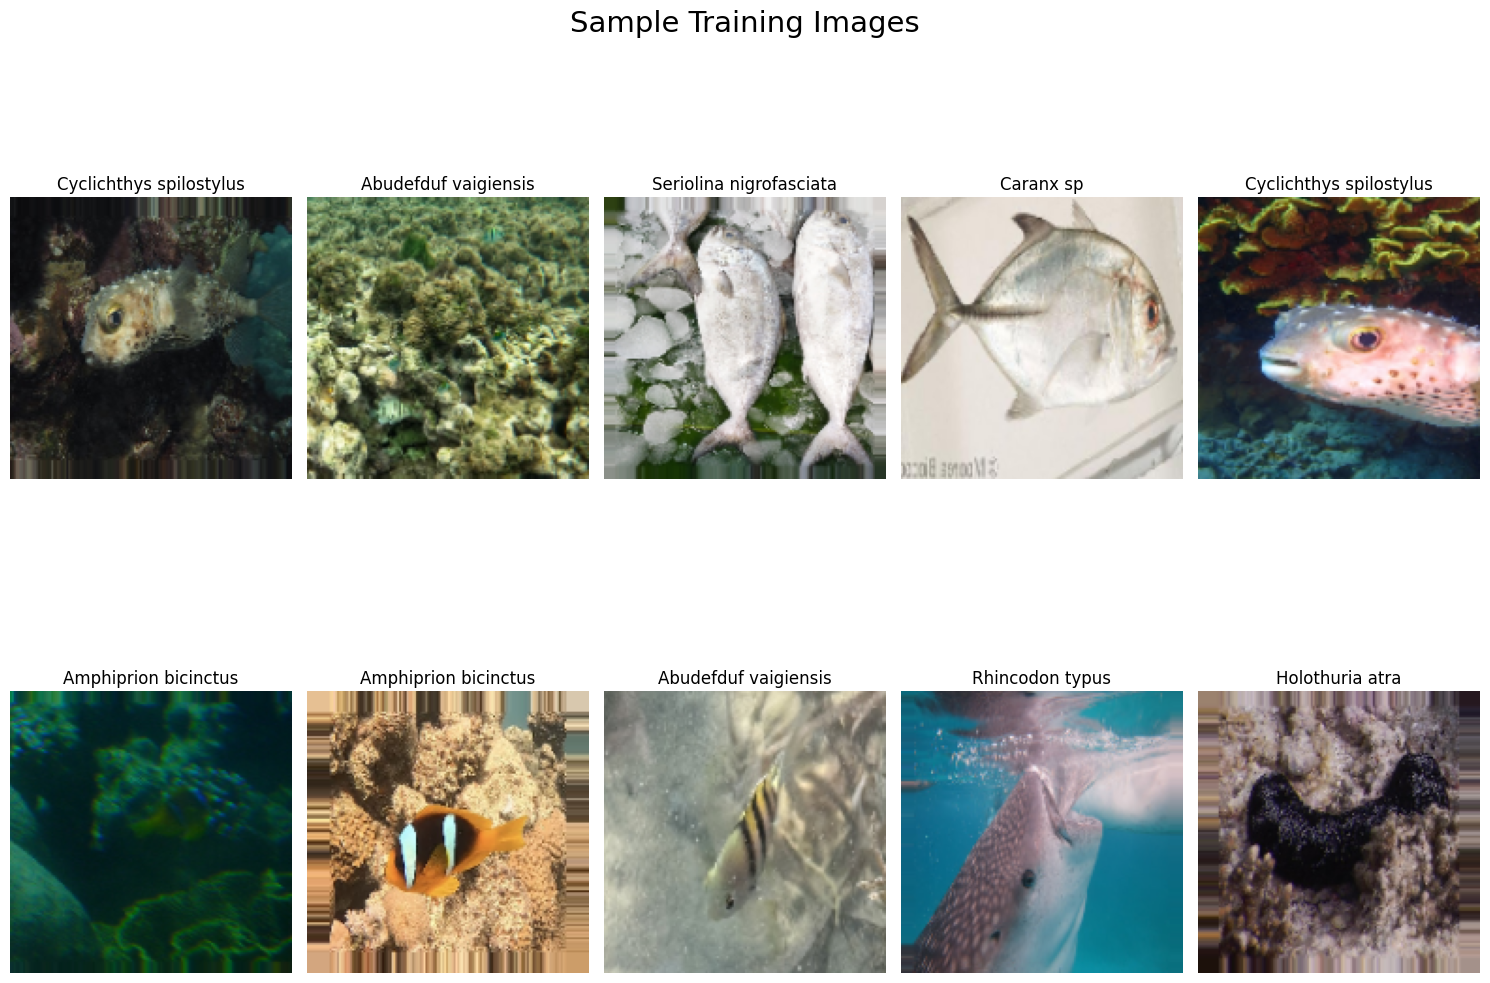

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

In [24]:
def create_model():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Flatten(),
        
        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=31, activation='softmax') 
    ])
    
    return model

ecoral_model = create_model()
print(ecoral_model.summary())

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 146, 146, 128)  │         9,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 146, 146, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 73, 73, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 73, 73, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 71, 71, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 71, 71, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 35, 35, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 35, 35, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 33, 33, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 33, 33, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 31)             │         7,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,208,255 (8.42 MB)

 Trainable params: 2,207,807 (8.42 MB)

 Non-trainable params: 448 (1.75 KB)

None


In [25]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)
optimizer = Adam(learning_rate=0.001)
ecoral_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [26]:
history = ecoral_model.fit(train_generator, epochs=10, validation_data=validation_generator, verbose=2, callbacks=[reduce_lr])

Epoch 1/10
75/75 - 75s - 1s/step - accuracy: 0.0797 - loss: 7.7989 - val_accuracy: 0.0476 - val_loss: 4.1915 - learning_rate: 0.0010
Epoch 2/10
75/75 - 49s - 656ms/step - accuracy: 0.1161 - loss: 6.1826 - val_accuracy: 0.0612 - val_loss: 4.1976 - learning_rate: 0.0010
Epoch 3/10
75/75 - 54s - 719ms/step - accuracy: 0.1695 - loss: 3.9247 - val_accuracy: 0.0629 - val_loss: 3.7254 - learning_rate: 0.0010
Epoch 4/10
75/75 - 53s - 702ms/step - accuracy: 0.2071 - loss: 3.1801 - val_accuracy: 0.0782 - val_loss: 3.4951 - learning_rate: 0.0010
Epoch 5/10
75/75 - 56s - 751ms/step - accuracy: 0.2501 - loss: 2.8147 - val_accuracy: 0.1463 - val_loss: 3.2468 - learning_rate: 0.0010
Epoch 6/10
75/75 - 54s - 723ms/step - accuracy: 0.2568 - loss: 2.6928 - val_accuracy: 0.1803 - val_loss: 2.8941 - learning_rate: 0.0010
Epoch 7/10
75/75 - 53s - 702ms/step - accuracy: 0.3111 - loss: 2.5026 - val_accuracy: 0.1990 - val_loss: 3.2289 - learning_rate: 0.0010
Epoch 8/10
75/75 - 55s - 729ms/step - accuracy: 0.3

In [27]:
history_additional = ecoral_model.fit(
    train_generator, 
    epochs=20,  #
    validation_data=validation_generator, 
    verbose=2, 
    callbacks=[reduce_lr]
)


Epoch 1/20
75/75 - 56s - 745ms/step - accuracy: 0.4046 - loss: 2.1586 - val_accuracy: 0.2585 - val_loss: 2.8851 - learning_rate: 0.0010
Epoch 2/20
75/75 - 52s - 690ms/step - accuracy: 0.4205 - loss: 2.0409 - val_accuracy: 0.2636 - val_loss: 3.0223 - learning_rate: 0.0010
Epoch 3/20
75/75 - 54s - 717ms/step - accuracy: 0.4192 - loss: 2.0494 - val_accuracy: 0.2653 - val_loss: 3.0112 - learning_rate: 0.0010
Epoch 4/20
75/75 - 55s - 728ms/step - accuracy: 0.4530 - loss: 1.9209 - val_accuracy: 0.1735 - val_loss: 3.6315 - learning_rate: 0.0010
Epoch 5/20
75/75 - 55s - 727ms/step - accuracy: 0.4605 - loss: 1.8359 - val_accuracy: 0.2449 - val_loss: 2.9224 - learning_rate: 0.0010
Epoch 6/20
75/75 - 54s - 726ms/step - accuracy: 0.4635 - loss: 1.7841 - val_accuracy: 0.2942 - val_loss: 3.0007 - learning_rate: 0.0010
Epoch 7/20
75/75 - 55s - 730ms/step - accuracy: 0.5269 - loss: 1.5798 - val_accuracy: 0.3163 - val_loss: 2.6812 - learning_rate: 3.1623e-04
Epoch 8/20
75/75 - 56s - 752ms/step - accura

In [28]:
history_additional = ecoral_model.fit(
    train_generator, 
    epochs=10,  
    validation_data=validation_generator, 
    verbose=2, 
    callbacks=[reduce_lr]
)

Epoch 1/10
75/75 - 56s - 747ms/step - accuracy: 0.7132 - loss: 0.9468 - val_accuracy: 0.3469 - val_loss: 2.6948 - learning_rate: 1.0000e-04
Epoch 2/10
75/75 - 56s - 749ms/step - accuracy: 0.7132 - loss: 0.9358 - val_accuracy: 0.3401 - val_loss: 2.6947 - learning_rate: 1.0000e-04
Epoch 3/10
75/75 - 54s - 716ms/step - accuracy: 0.7299 - loss: 0.8969 - val_accuracy: 0.3622 - val_loss: 2.6765 - learning_rate: 1.0000e-04
Epoch 4/10
75/75 - 53s - 711ms/step - accuracy: 0.7240 - loss: 0.9148 - val_accuracy: 0.3622 - val_loss: 2.7908 - learning_rate: 1.0000e-04
Epoch 5/10
75/75 - 49s - 660ms/step - accuracy: 0.7198 - loss: 0.9062 - val_accuracy: 0.3571 - val_loss: 2.7279 - learning_rate: 1.0000e-04
Epoch 6/10
75/75 - 54s - 716ms/step - accuracy: 0.7265 - loss: 0.8686 - val_accuracy: 0.3588 - val_loss: 2.7169 - learning_rate: 1.0000e-04
Epoch 7/10
75/75 - 58s - 771ms/step - accuracy: 0.7257 - loss: 0.8543 - val_accuracy: 0.3622 - val_loss: 2.7157 - learning_rate: 1.0000e-04
Epoch 8/10
75/75 - 5

In [31]:
val_loss, val_acc = ecoral_model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 310ms/step - accuracy: 0.3574 - loss: 2.6886
Validation Loss: 2.6963
Validation Accuracy: 36.05%


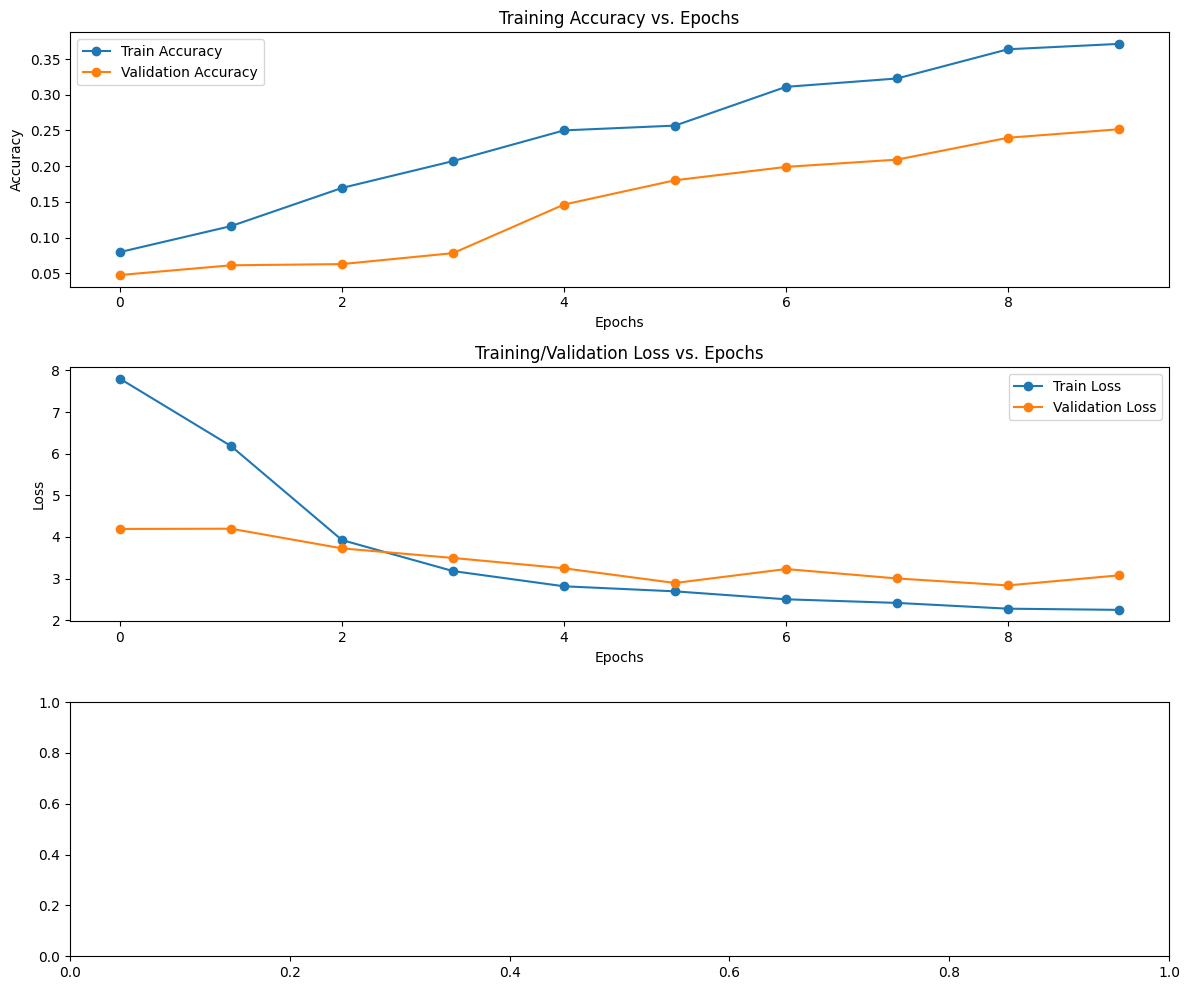

In [33]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()


In [34]:
ecoral_model.save('ecoral_species_classifier_model.h5')


In [4]:
from tensorflow.keras.models import load_model
ecoral_model = load_model('ecoral_species_classifier_model.h5')
